# Turbine Power Data

## Using the data provided in the csv file the task is to predict power output for the next 15 days.

### https://www.kaggle.com/datasets/theforcecoder/wind-power-forecasting

In [370]:
# import packages
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import math
from scipy.optimize import curve_fit
import pandas_profiling
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm # for SARIMAX algorith

import xgboost as xgb # for XGBoost algorith
from sklearn.ensemble import RandomForestRegressor # for RandomForest regressor
# LSTM imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
# for scaling
from sklearn.preprocessing import MinMaxScaler

In [371]:
# to get the plots to show in the same size
%matplotlib inline
plt.rcParams['figure.figsize'] = (18,8)

# Import the data 
## by viewing the csv the column Unnamed:0 is the date column so import it as such and then set it as a datetime

In [372]:
# import the data and set the time column as the index

df = pd.read_csv('/home/chris/kaggle/Wind_Power_Forecasting/Turbine_Data.csv', parse_dates=['Unnamed: 0'],index_col=['Unnamed: 0'])

In [373]:
df.index = pd.to_datetime(df.index)

In [374]:
df.columns

Index(['ActivePower', 'AmbientTemperatue', 'BearingShaftTemperature',
       'Blade1PitchAngle', 'Blade2PitchAngle', 'Blade3PitchAngle',
       'ControlBoxTemperature', 'GearboxBearingTemperature',
       'GearboxOilTemperature', 'GeneratorRPM', 'GeneratorWinding1Temperature',
       'GeneratorWinding2Temperature', 'HubTemperature', 'MainBoxTemperature',
       'NacellePosition', 'ReactivePower', 'RotorRPM', 'TurbineStatus', 'WTG',
       'WindDirection', 'WindSpeed'],
      dtype='object')

In [375]:
df

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,...,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WTG,WindDirection,WindSpeed
2017-12-31 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
2017-12-31 00:10:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
2017-12-31 00:20:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
2017-12-31 00:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
2017-12-31 00:40:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,G01,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-30 23:10:00+00:00,70.044465,27.523741,45.711129,1.515669,1.950088,1.950088,0.0,59.821165,55.193793,1029.870744,...,58.148777,39.008931,36.476562,178.0,13.775785,9.234004,2.0,G01,178.0,3.533445
2020-03-30 23:20:00+00:00,40.833474,27.602882,45.598573,1.702809,2.136732,2.136732,0.0,59.142038,54.798545,1030.160478,...,57.550367,39.006759,36.328125,178.0,8.088928,9.229370,2.0,G01,178.0,3.261231
2020-03-30 23:30:00+00:00,20.777790,27.560925,45.462045,1.706214,2.139664,2.139664,0.0,58.439439,54.380456,1030.137822,...,57.099335,39.003815,36.131944,178.0,4.355978,9.236802,2.0,G01,178.0,3.331839
2020-03-30 23:40:00+00:00,62.091039,27.810472,45.343827,1.575352,2.009781,2.009781,0.0,58.205413,54.079014,1030.178178,...,56.847239,39.003815,36.007805,190.0,12.018077,9.237374,2.0,G01,190.0,3.284468


In [376]:
# total number of values in the data frame
len(df)

118224

## Check for duplicate entries - 23039 duplicates, when droped the df has 95185 unique entries

In [377]:
# check for duplicates
df.duplicated().sum()

23039

In [378]:
# drop the duplicates
df.drop_duplicates(inplace=True)

In [379]:
len(df)

95185

# Exploratory data analysis - using pandas profiling and then some boxplots. 

## Distributions of the data for each variable can be seen along with the missing values by using the pandas profiling package - also ControlBoxTemperature and WTG are not a useful. 

## A correlation graph is shown but I derive one later and explain things further. Also check for duplicates and drop them is there are any. 

## Also note box plot for ActivePower goes below zero - seems a bit odd that you can have negative power?? So will drop negative power values too.

In [380]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 95185 entries, 2017-12-31 00:00:00+00:00 to 2020-03-30 23:50:00+00:00
Data columns (total 21 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ActivePower                   94624 non-null  float64
 1   AmbientTemperatue             93698 non-null  float64
 2   BearingShaftTemperature       62380 non-null  float64
 3   Blade1PitchAngle              41987 non-null  float64
 4   Blade2PitchAngle              41882 non-null  float64
 5   Blade3PitchAngle              41882 non-null  float64
 6   ControlBoxTemperature         62022 non-null  float64
 7   GearboxBearingTemperature     62402 non-null  float64
 8   GearboxOilTemperature         62430 non-null  float64
 9   GeneratorRPM                  62287 non-null  float64
 10  GeneratorWinding1Temperature  62419 non-null  float64
 11  GeneratorWinding2Temperature  62441 non-null  float64
 12  HubTemperatur

In [381]:
df.describe()

,ActivePower,AmbientTemperatue,BearingShaftTemperature,Blade1PitchAngle,Blade2PitchAngle,Blade3PitchAngle,ControlBoxTemperature,GearboxBearingTemperature,GearboxOilTemperature,GeneratorRPM,GeneratorWinding1Temperature,GeneratorWinding2Temperature,HubTemperature,MainBoxTemperature,NacellePosition,ReactivePower,RotorRPM,TurbineStatus,WindDirection,WindSpeed
count,94624.000000,93698.000000,62380.000000,41987.000000,41882.000000,41882.000000,62022.0,62402.000000,62430.000000,62287.000000,62419.000000,62441.000000,62268.000000,62369.000000,72108.000000,94622.000000,62119.000000,6.275900e+04,72108.000000,94469.000000
mean,619.036994,28.777569,43.105338,9.751759,10.038709,10.038709,0.0,64.376222,57.561706,1102.146658,72.462897,71.829134,36.979752,39.635107,196.307894,88.070309,9.908585,2.284016e+03,196.307894,5.879193
std,610.917748,4.358470,5.168850,20.646533,20.272100,20.272100,0.0,10.020754,6.324124,527.967896,22.626685,22.649494,4.884101,5.428555,88.279316,116.498176,4.717546,3.590288e+05,88.279316,2.617241
min,-38.524659,0.000000,0.000000,-43.156734,-26.443415,-26.443415,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-203.182591,0.000000,0.000000e+00,0.000000,0.000000
25%,80.098952,25.625603,39.856871,-0.939896,-0.433316,-0.433316,0.0,57.925129,53.944023,1029.812895,55.492241,54.763998,33.977709,35.843574,145.000000,-0.433723,9.231097,2.000000e+00,145.000000,3.824572
50%,402.880706,28.338961,42.927465,0.395038,0.889782,0.889782,0.0,64.862406,57.197064,1124.930500,65.792061,65.006679,37.003815,39.500759,182.000000,35.938526,10.099272,2.000000e+00,182.000000,5.558520
75%,1073.979105,31.665910,47.018075,8.101939,8.481306,8.481306,0.0,71.104401,61.307270,1515.517020,85.874609,85.342714,40.009538,43.370342,271.000000,147.190453,13.600908,2.000000e+00,271.000000,7.505555
max,1779.032433,42.405597,55.088655,90.143610,90.017830,90.017830,0.0,82.237932,70.764581,1809.941700,126.773031,126.043018,47.996185,54.250000,357.000000,403.713620,16.273495,6.574653e+07,357.000000,22.970893


In [382]:
# Use panda_profiling library to investigate the data
#pandas_profiling.ProfileReport(df)

In [383]:
# Need to drop WTG column as it is always G01
df.drop('WTG', axis=1, inplace=True)
df.drop('ControlBoxTemperature', axis=1, inplace=True)

In [384]:
df.columns

Index(['ActivePower', 'AmbientTemperatue', 'BearingShaftTemperature',
       'Blade1PitchAngle', 'Blade2PitchAngle', 'Blade3PitchAngle',
       'GearboxBearingTemperature', 'GearboxOilTemperature', 'GeneratorRPM',
       'GeneratorWinding1Temperature', 'GeneratorWinding2Temperature',
       'HubTemperature', 'MainBoxTemperature', 'NacellePosition',
       'ReactivePower', 'RotorRPM', 'TurbineStatus', 'WindDirection',
       'WindSpeed'],
      dtype='object')

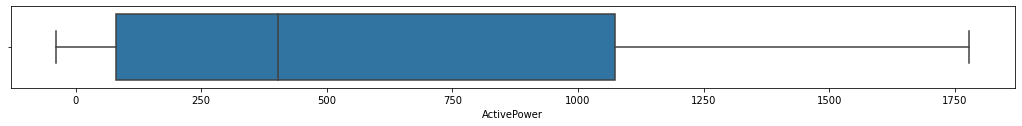

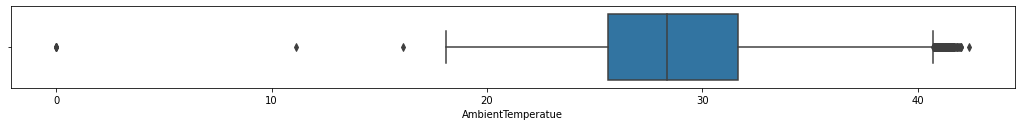

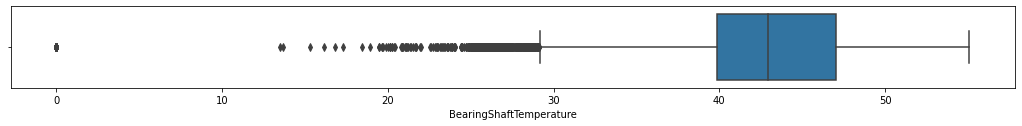

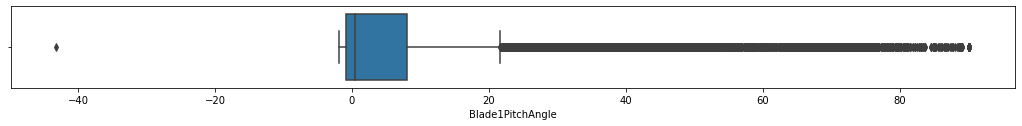

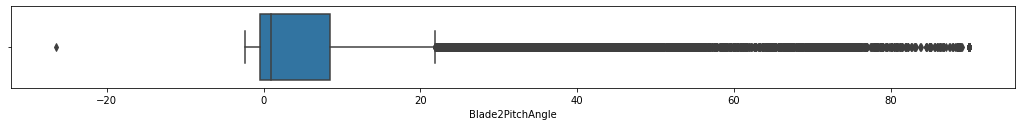

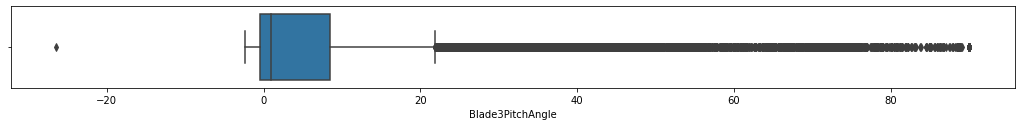

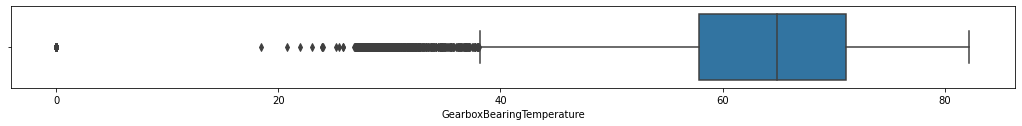

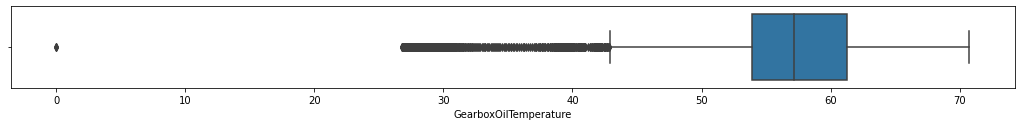

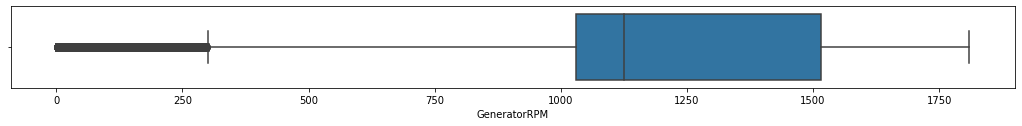

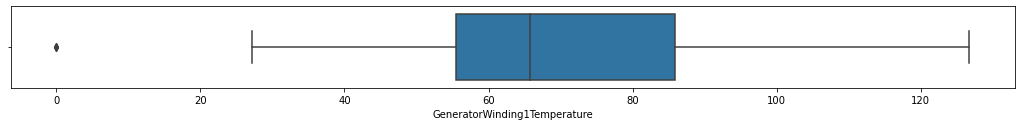

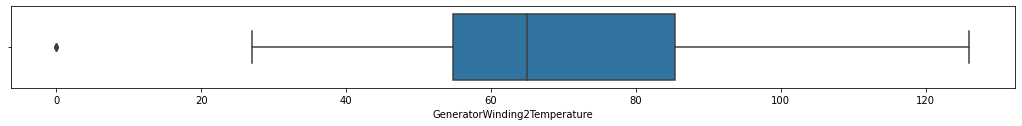

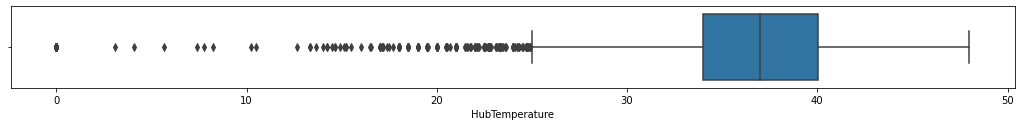

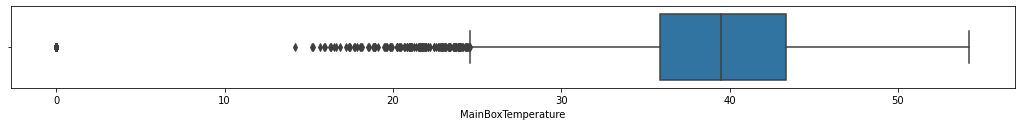

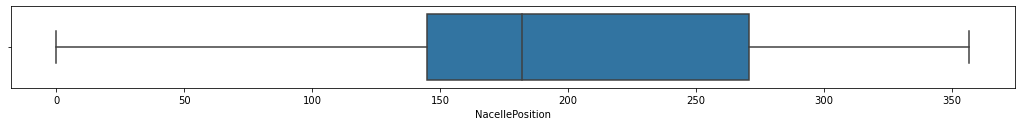

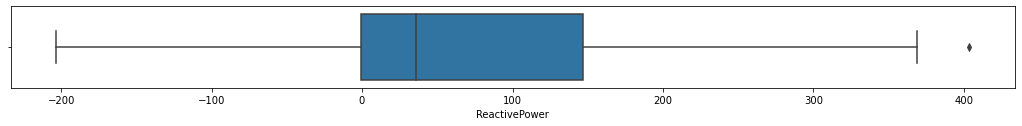

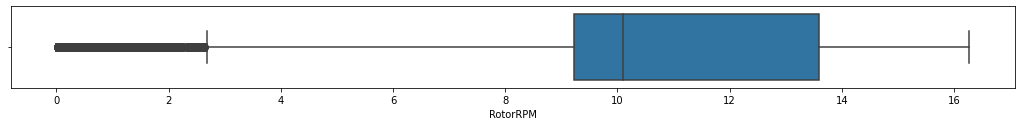

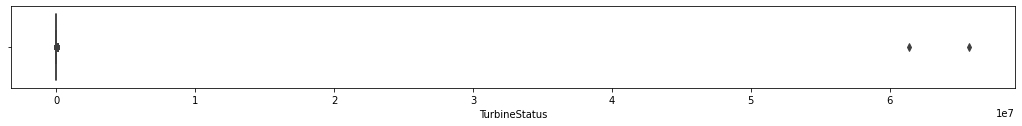

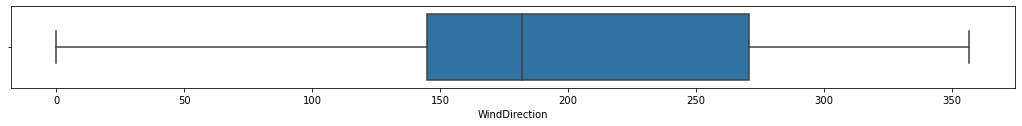

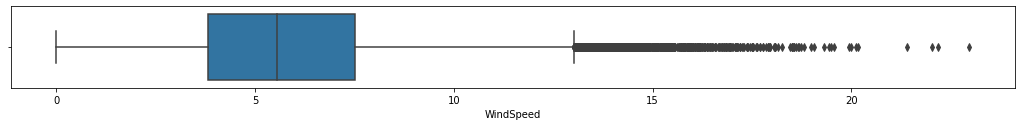

In [385]:
# Boxplots of all the data
for column in df:    
    fig,ax = plt.subplots(figsize=(18,1.5))
    sns.boxplot(data=df, x=column) 

# Missing values - there are missing values for all fields with 2018 having the most missing data. If we look at the ActivePower field there is roughly 0.6% of the data missing (561/94750) - there should be enough for a reasonable prediction (the nas will be dropped once the dataset is reduced) - no need to impute missing values.

In [386]:
# from the above panda profile there are lots os missing values - a quick summary is given below
df.isna().sum()

ActivePower                       561
AmbientTemperatue                1487
BearingShaftTemperature         32805
Blade1PitchAngle                53198
Blade2PitchAngle                53303
Blade3PitchAngle                53303
GearboxBearingTemperature       32783
GearboxOilTemperature           32755
GeneratorRPM                    32898
GeneratorWinding1Temperature    32766
GeneratorWinding2Temperature    32744
HubTemperature                  32917
MainBoxTemperature              32816
NacellePosition                 23077
ReactivePower                     563
RotorRPM                        33066
TurbineStatus                   32426
WindDirection                   23077
WindSpeed                         716
dtype: int64

In [387]:
# Look at this for each year to see if more data is missing for different years.
for yr in df.index.year.unique():
    print('\nYear',yr,'\n', df[df.index.year==yr].isna().sum())


Year 2017 
 ActivePower                     1
AmbientTemperatue               1
BearingShaftTemperature         1
Blade1PitchAngle                1
Blade2PitchAngle                1
Blade3PitchAngle                1
GearboxBearingTemperature       1
GearboxOilTemperature           1
GeneratorRPM                    1
GeneratorWinding1Temperature    1
GeneratorWinding2Temperature    1
HubTemperature                  1
MainBoxTemperature              1
NacellePosition                 1
ReactivePower                   1
RotorRPM                        1
TurbineStatus                   1
WindDirection                   1
WindSpeed                       1
dtype: int64

Year 2018 
 ActivePower                        73
AmbientTemperatue                  69
BearingShaftTemperature         31335
Blade1PitchAngle                35361
Blade2PitchAngle                35361
Blade3PitchAngle                35361
GearboxBearingTemperature       31335
GearboxOilTemperature           31332
GeneratorRP

## The last thing to check is if there are any negative values for ActivePower - and drop them - as you cannot have negative power generation so there must be an issue with them. There are in fact 15629 entries with negative 'ActivePower' - these all seem to happen at low wind speed, however, there are occasions with similar windspeeds and the ActivePower is 0 so it is likely they are a incorrect readings and so they will be dropped

In [388]:
# check entries with negative values for ActivePower  - for comparison can also use df['ActivePower']==0 to see wind speeds when no power generated
cols = ['ActivePower','WindSpeed']
df[cols][df['ActivePower']<0]

,ActivePower,WindSpeed
2018-01-01 00:00:00+00:00,-5.357727,2.279088
2018-01-01 00:10:00+00:00,-5.822360,2.339343
2018-01-01 00:20:00+00:00,-5.279409,2.455610
2018-01-01 00:30:00+00:00,-4.648054,2.026754
2018-01-01 00:40:00+00:00,-4.684632,1.831420
...,...,...
2020-03-30 03:50:00+00:00,-7.005695,2.505505
2020-03-30 04:00:00+00:00,-5.576951,2.174616
2020-03-30 04:10:00+00:00,-4.945515,2.333189
2020-03-30 04:20:00+00:00,-6.565684,2.946595


In [389]:
# Now to remove the negative ActivePower values - or more importantly only select the ones above 0 !
cols = ['ActivePower','WindSpeed']
df =  df[df['ActivePower']>=0]

In [390]:
# total number of NaN Activepower readings
total_na = df['ActivePower'].isna().sum()  # 0
# count the number of non na values
total = df['ActivePower'].count()          # 78698
# percentage missing 
print('Percentage of missing values {}%'.format(round(total_na/total,2)*100))     # 0.0  

Percentage of missing values 0.0%


# Graph power production 
## First using all the data first (but as there is a reading every 10 minutes it is very messy), then resampling the mean daily values to view more clearly.
## A pattern emerges from the daily mean data, there are power output maxima in July, August and September.Graph

Text(0, 0.5, 'Power Generated')

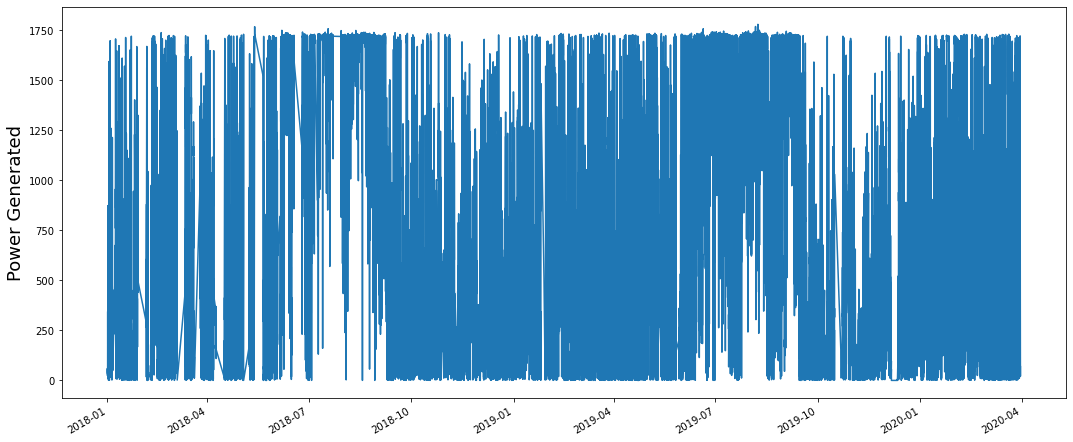

In [391]:
# Power output 
df['ActivePower'].plot()
plt.ylabel('Power Generated', fontsize=18)

Text(0, 0.5, 'Mean Daily Power Generated')

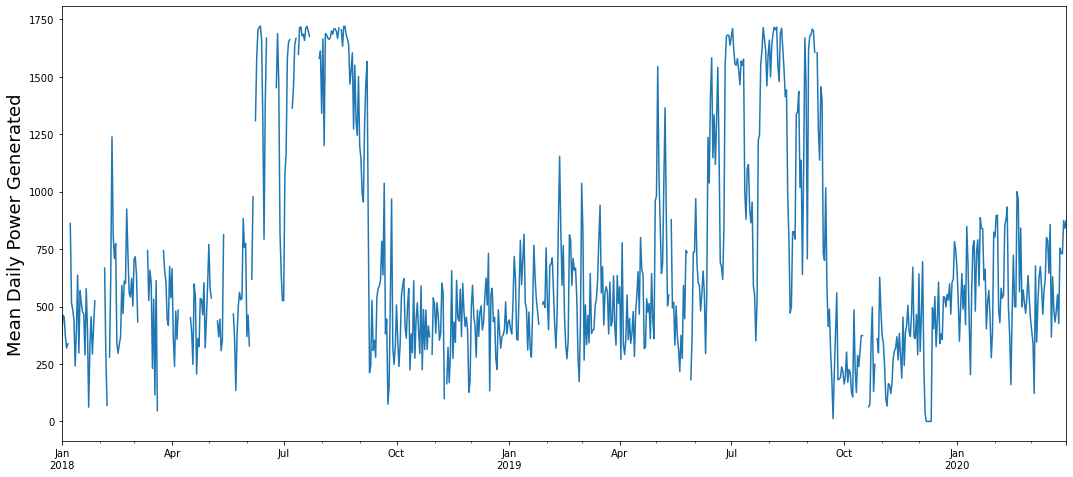

In [392]:
# Resampling dai
df['ActivePower'].resample('D').mean().plot()
plt.ylabel('Mean Daily Power Generated', fontsize=18)

## Obviously a wind turbine is going to generate the most power in windy conditions so now plot the daily mean wind (the missing values can be seen) to see if there is a similar pattern in the graph (hint: there is !!)

Text(0, 0.5, 'Wind Speed')

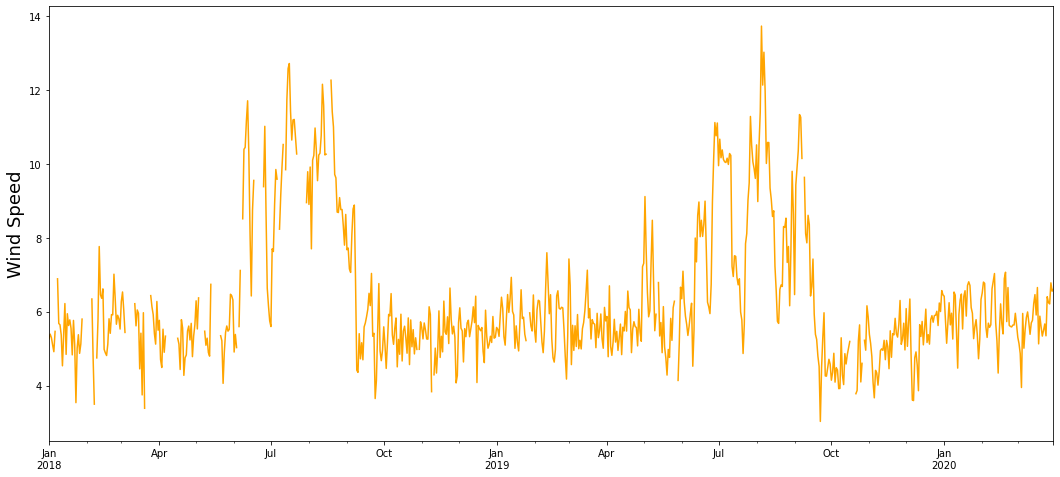

In [393]:
df['WindSpeed'].resample('D').mean().plot(color='orange')
plt.ylabel('Wind Speed', fontsize=18)

cols = ['ActivePower','WindSpeed']
df[cols][df['ActivePower']<0].plot()# Graph together
## If both above graphs are overlaid - with wind speed multiplied by 100 to get to the same scale the pattern and correlation is easily evident. Daily and monthly resampling values are graphed to make the point. But the correlation is obvious.

Text(0, 0.5, 'Active pPower and Wind speed*100')

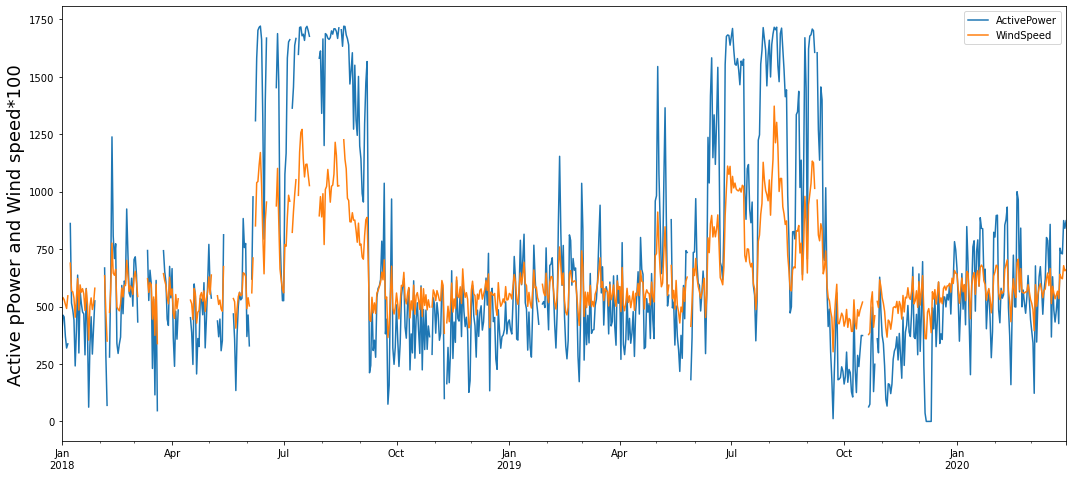

In [394]:
# Graph together
df['ActivePower'].resample('D').mean().plot(legend=True)
(df['WindSpeed']*100).resample('D').mean().plot(legend=True)
plt.ylabel('Active pPower and Wind speed*100', fontsize=18)

Text(0, 0.5, 'Active pPower and Wind speed*100')

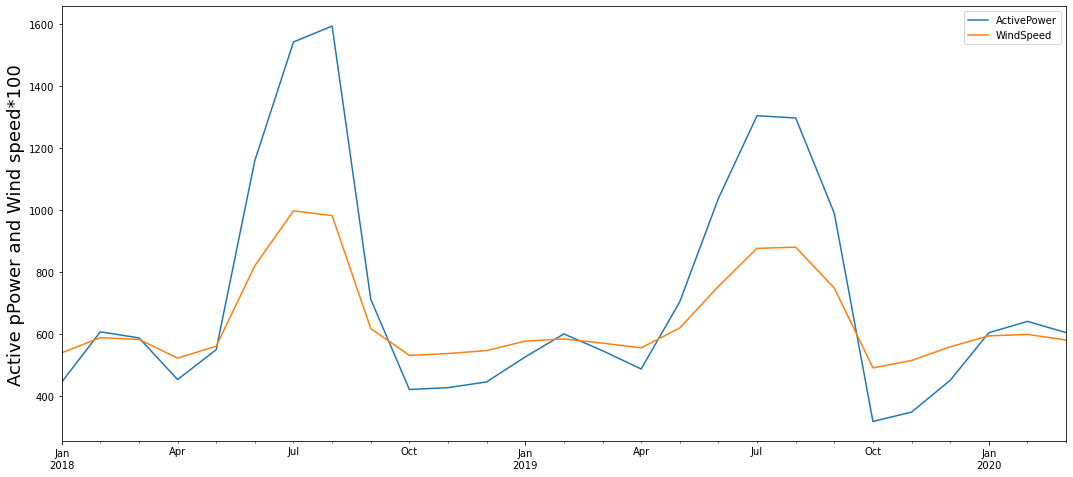

In [395]:
# Graph together
df['ActivePower'].resample('M').mean().plot(legend=True)
(df['WindSpeed']*100).resample('M').mean().plot(legend=True)
plt.ylabel('Active pPower and Wind speed*100', fontsize=18)

# What about other correlations ?

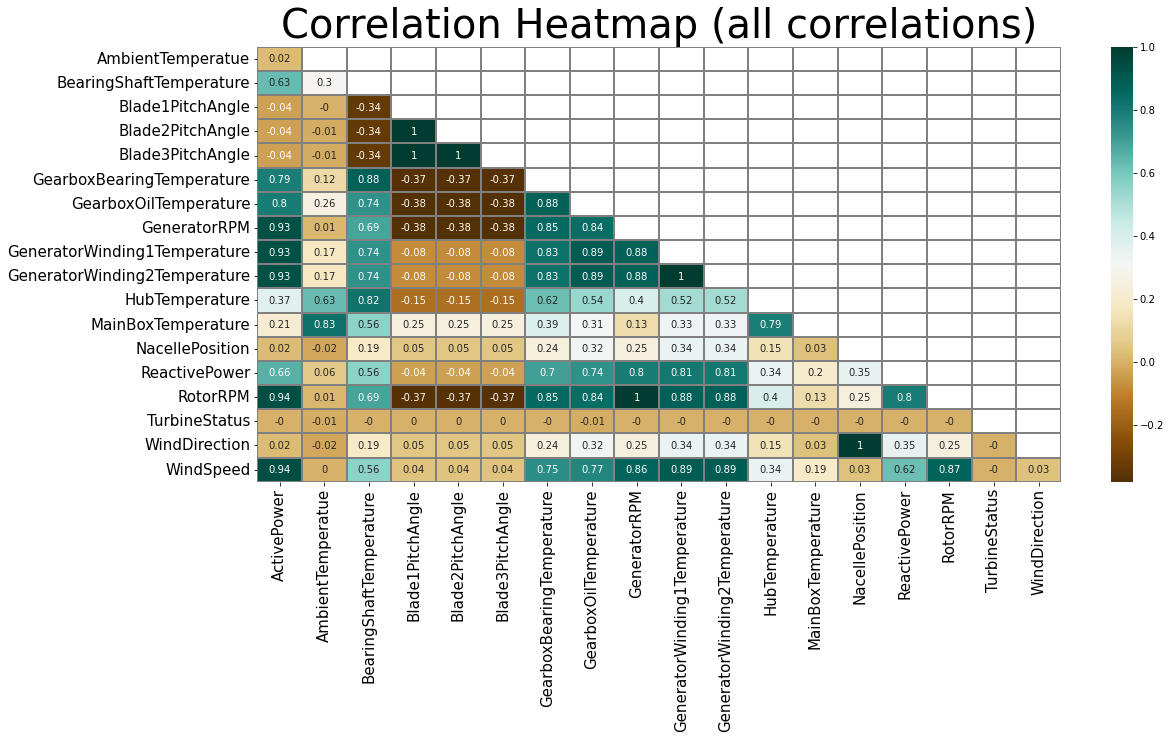

In [396]:
# To find the correlation among the columns using pearson method 

corr_matrix = df.corr().round(2) # add .abs() if not worried about positive or negative correlation just the strength

# use this to show only lower triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cut_off = -1 # to show all correlations

mask |= np.abs(corr_matrix) < cut_off
corr = corr_matrix[~mask]  # fill in NaN in the non-desired cells
# reove empty rows/columns to make it easier to read.
remove_empty_rows_and_cols = True
if remove_empty_rows_and_cols:
    wanted_cols = np.flatnonzero(np.count_nonzero(~mask, axis=1))
    wanted_rows = np.flatnonzero(np.count_nonzero(~mask, axis=0))
    corr = corr.iloc[wanted_cols, wanted_rows]
# display the correlation value in a grid to make it easier to read.
s = sns.heatmap(corr,annot=True,  linewidths=0.1, linecolor='gray', cmap="BrBG")
# increase the size of the labels.
s.set_title('Correlation Heatmap (all correlations)', fontsize=40)
s.set_xticklabels(s.get_xmajorticklabels(), fontsize = 15)
s.set_yticklabels(s.get_ymajorticklabels(), fontsize = 15)
plt.show()

In [397]:
5# Another way of viewing specific correlations
correlations = df.corr().unstack().sort_values(ascending=False) 

# checking  ActivePower correlations
correlations['ActivePower'].drop_duplicates()  # change the required field here to get the specific correlations

ActivePower                     1.000000
WindSpeed                       0.937870
RotorRPM                        0.935928
GeneratorRPM                    0.934303
GeneratorWinding2Temperature    0.928769
GeneratorWinding1Temperature    0.927517
GearboxOilTemperature           0.801319
GearboxBearingTemperature       0.786150
ReactivePower                   0.662808
BearingShaftTemperature         0.631922
HubTemperature                  0.372788
MainBoxTemperature              0.207514
NacellePosition                 0.024547
AmbientTemperatue               0.019064
TurbineStatus                  -0.001115
Blade1PitchAngle               -0.042637
Blade3PitchAngle               -0.042700
dtype: float64

## Drop the columns that are not correlated to the ActivePower column and also some columns that are correlated to each other. In fact the only features that are not related to the turbine - such as GearBoxOilTemperature for example - are the ambient temperature, the wind speed and wind direction (which make sense since it is a wind turtbine that uses the wind to generate power !!). Wind direction and ambient temperature are only correlated in a very minor way. So let's just keep the wind speed and see how that goes (and now the NaNs can be dropped coincidentally WindSpeed has the least NaN values compared to the other fields).

In [398]:
df = df[['ActivePower','WindSpeed']]
# now to drop the na values
df = df.dropna()

# Look for a pattern of power generation versus wind speed. 
## Here we can see that the wind speed needs to be about 2.5m/s to turn the turbine and start generating power. And the maximum wind power is generated at about 8m/s - wind speeds fater than that do not generate any more power (this must be a function of the turbine).
## There is some noise in the graph but a fairly simple function can be used to describe the data. It is almost linear but a Sigmoid function (exponential) will capture the minimum and maximum features better
## I had discovered this feature whilst doing another kaggle entry - see it here - https://www.kaggle.com/code/chrismat10/texas-turbine-regression-and-curve-fit

Text(0.5, 1.0, 'Power output versus wind speed')

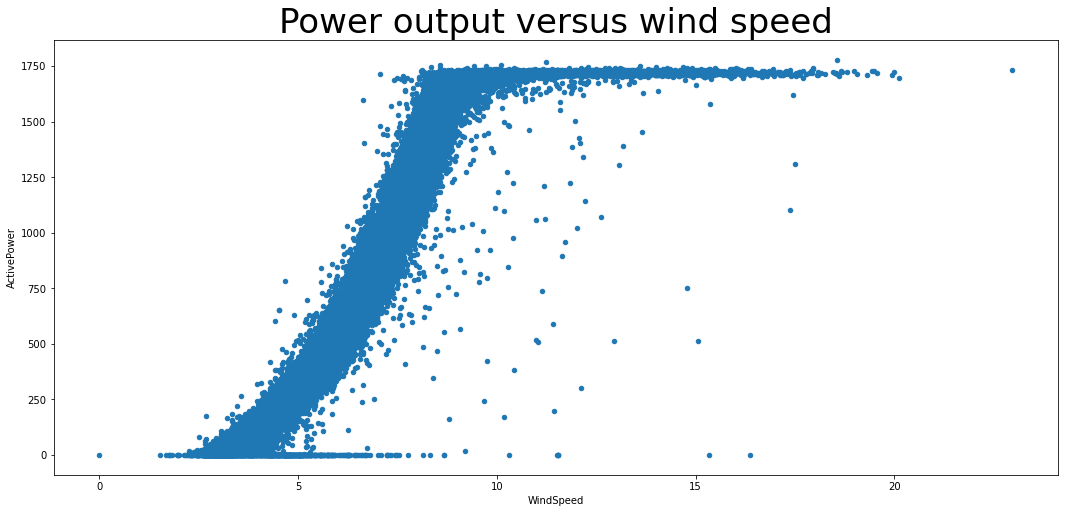

In [399]:
df.plot.scatter(y='ActivePower', x='WindSpeed')
plt.title('Power output versus wind speed', fontsize=34 )

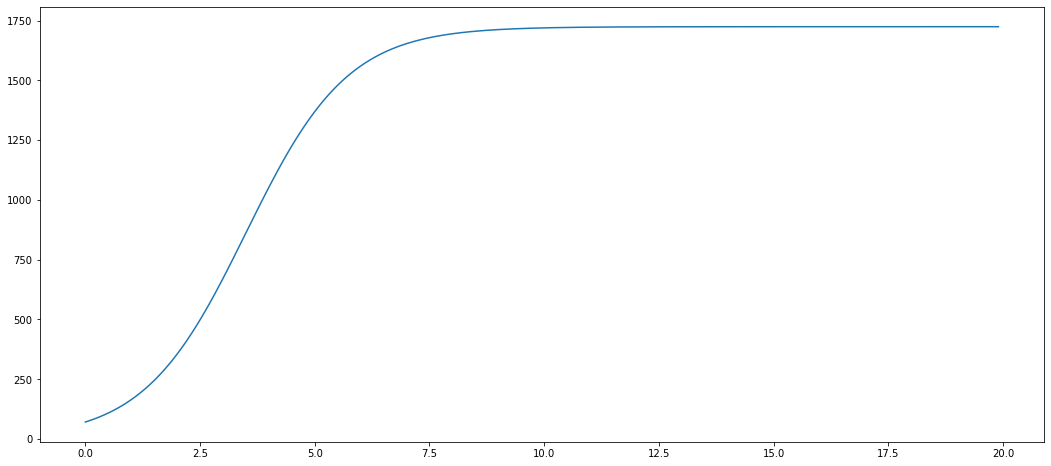

In [400]:
# The graph has the same shape as the one above.

X = np.arange(0, 20, 0.1)
Y = 1725 / (1.0 + np.exp(0.9*(-X+3.5)))
plt.plot(X,Y) 
plt.show()


# Define a function to plot this graph and then use curve_fit from scipy to solve for the optimal parameters and finally graph against the measured values. Transparency of measured values is set very low - hence the outliers look like they have disappeared

In [401]:
# Define a funcation for the graph to be used for prediction - 
def graph_func(X,c1,c2):
    return 1725 / (1.0 + np.exp(c1*(-X+c2)))

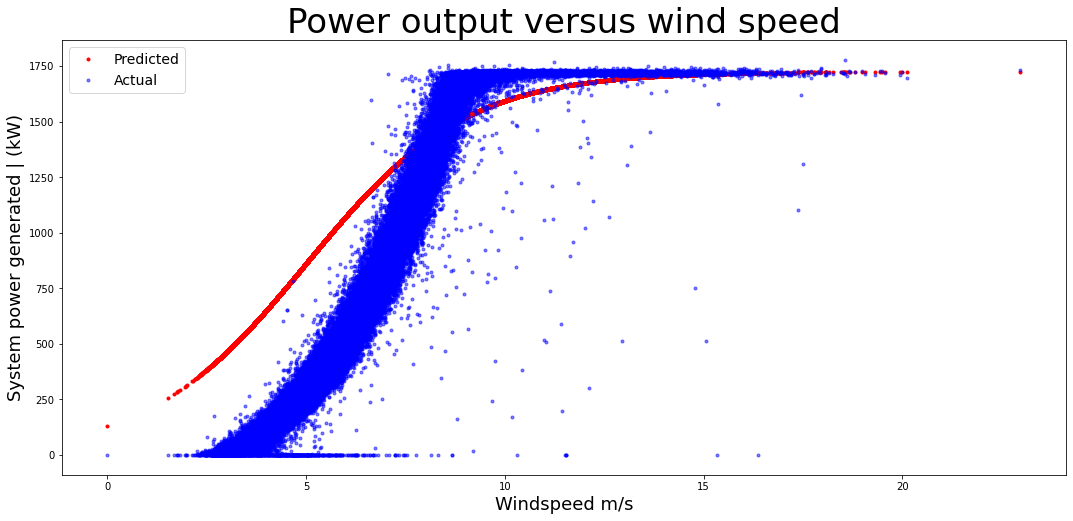

In [402]:
# define and empty array to put the power predictions into
n = len(df['WindSpeed'])
# first guess for the curve parameters - play around with these to get a better shaped curve
c = [0.5, 5]
predicted_power = np.empty(n)
for i in range(n):
    predicted_power[i] = graph_func(df['WindSpeed'][i],c[0],c[1]) # use initial guesses
    
plt.plot(df['WindSpeed'],predicted_power,'r.')
plt.plot(df['WindSpeed'],df['ActivePower'],'b.', alpha=0.5 )
plt.ylabel('System power generated | (kW)', fontsize=18)
plt.xlabel('Windspeed m/s', fontsize=18)
plt.title('Power output versus wind speed', fontsize=34 )
plt.legend(['Predicted','Actual'], fontsize=14)

In [403]:
# now to use curve_fit

c,cov = curve_fit(graph_func,df['WindSpeed'],df['ActivePower'],[0.5,5])
print(c)

[0.98314562 6.85678335]


## Now to do the plot again with the new curve_fit solved values

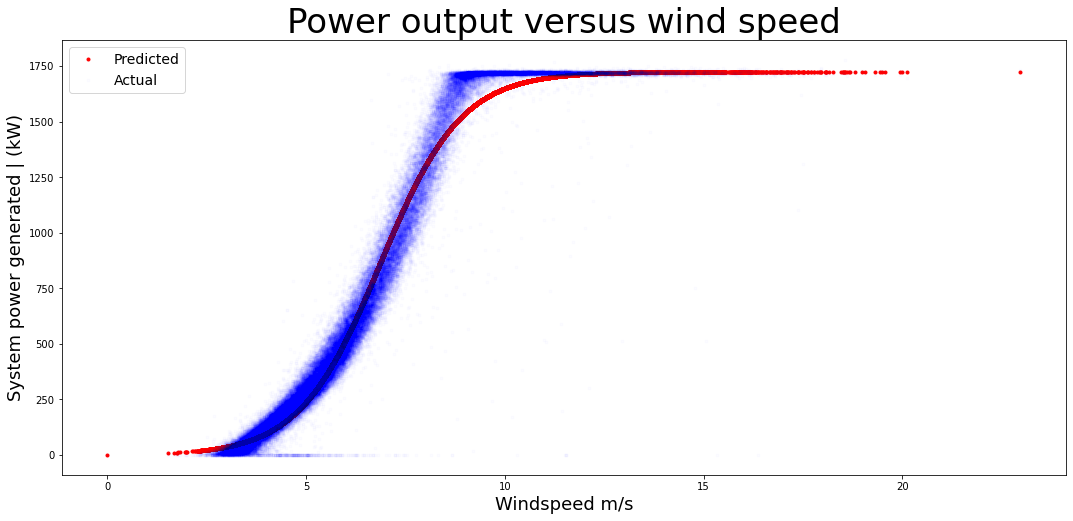

In [404]:
# define and empty array to put the power predictions into
n = len(df['WindSpeed'])

predicted_power = np.empty(n)
for i in range(n):
    predicted_power[i] = graph_func(df['WindSpeed'][i],c[0],c[1]) # use values calculated in the curve_fit equation above
    
plt.plot(df['WindSpeed'],predicted_power,'r.')
plt.plot(df['WindSpeed'],df['ActivePower'],'b.', alpha=0.01 )
plt.ylabel('System power generated | (kW)', fontsize=18)
plt.xlabel('Windspeed m/s', fontsize=18)
plt.title('Power output versus wind speed', fontsize=34 )
plt.legend(['Predicted','Actual'], fontsize=14)

# Accuracy statistics - the R squared is excellent for this method - and so with the next 15 days wind speeds we could easily forecast the power output with 97% accuracy.

In [405]:

print('The Coefficient of determination (R-squared) = {:.2f}'.format(r2_score(df['ActivePower'],predicted_power)))
print('The mean absolute error (MAE) for            = {:.2f}'.format(mean_absolute_error(df['ActivePower'],predicted_power)))
print('The RMSE error (RMSE) for                    = {:.2f}'.format(mean_squared_error(df['ActivePower'],predicted_power, squared=False)))

The Coefficient of determination (R-squared) = 0.97
The mean absolute error (MAE) for            = 67.74
The RMSE error (RMSE) for                    = 96.86


# However, this was not the task here - as stated in the dataset context -

## 'A long term wind forecasting technique is thus required'. So based on 2 and a bit years worth of data the wind for the next 15 days should be forecast - and hence the wind power that can be generated. 

## As this is time series analysis with an obvious seasonal component - shown in the monthly graphs below (max in June, July and August for power generation and wind) - some time series techniques need to be employed.


Text(0.5, 1.0, 'Monthly boxplots of Power Generated')

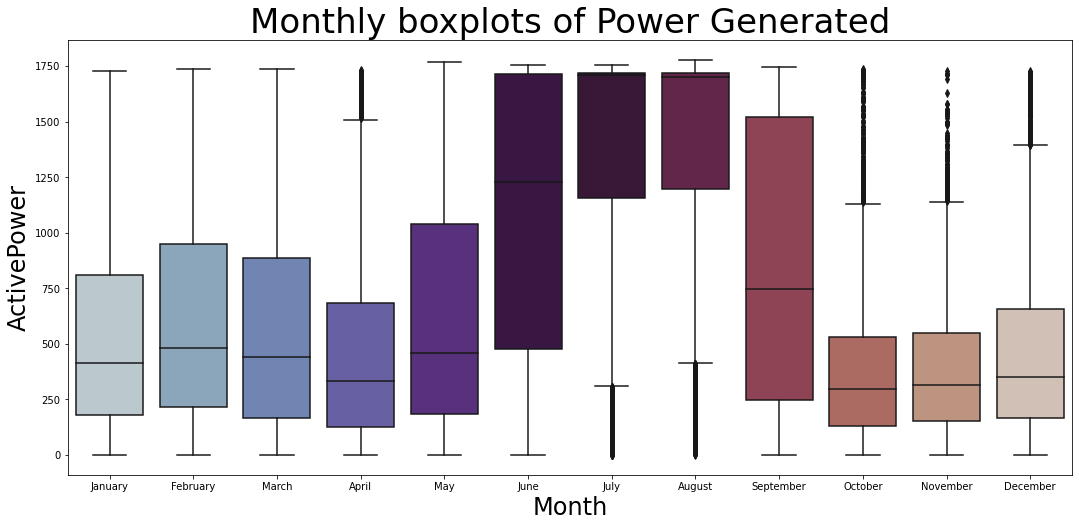

In [406]:
# Now to visualise amount generated by month
sns.boxplot(x=df.index.month_name(), y='ActivePower', data=df, palette="twilight")
plt.ylabel('ActivePower', fontsize=24)
plt.xlabel('Month', fontsize=24)
plt.title("Monthly boxplots of Power Generated", fontsize=34)

Text(0.5, 1.0, 'Monthly boxplots of Wind Speed')

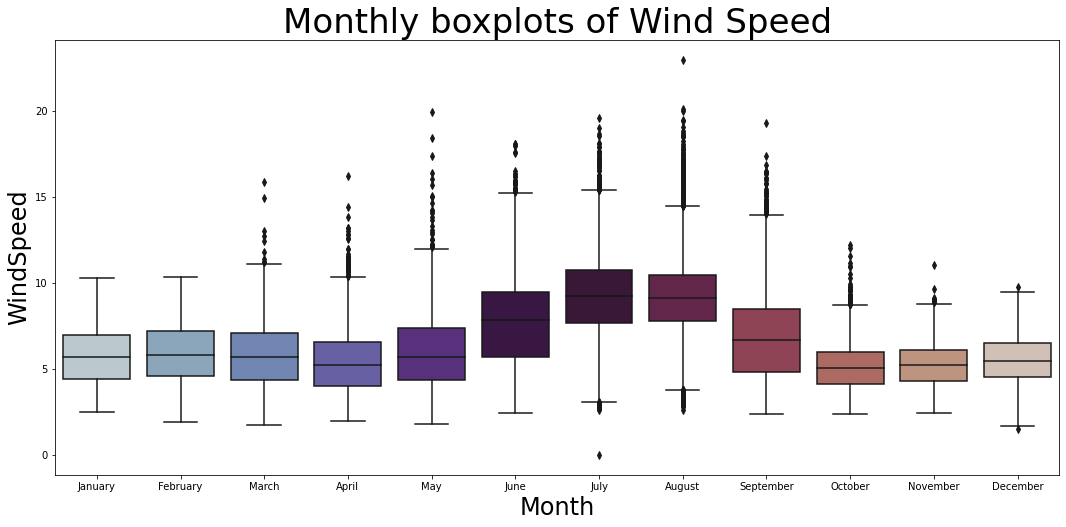

In [407]:
# Now to visualise amount generated by month
sns.boxplot(x=df.index.month_name(), y='WindSpeed', data=df, palette="twilight")
plt.ylabel('WindSpeed', fontsize=24)
plt.xlabel('Month', fontsize=24)
plt.title("Monthly boxplots of Wind Speed", fontsize=34)

## Graph of hourly power generation - shows as expected it is generally windier in the afternoon and hence more power is generated in the afternoon - but it can be generated at any time of course..

Text(0.5, 1.0, 'Hourly boxplots of Wind Speed')

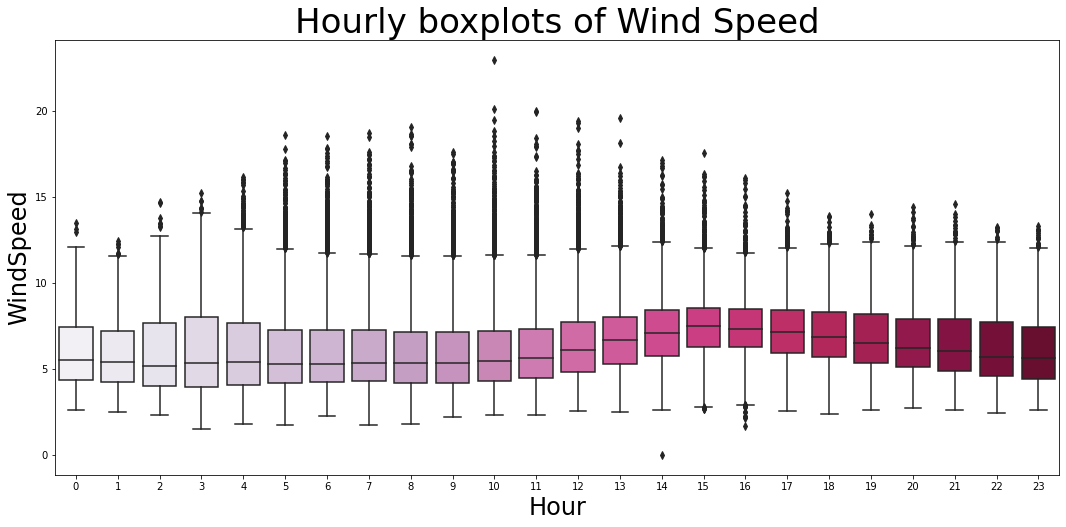

In [408]:
# Now to visualise amount generated by hour
sns.boxplot(x=df.index.hour, y='WindSpeed', data=df, palette="PuRd")
plt.ylabel('WindSpeed', fontsize=24)
plt.xlabel('Hour', fontsize=24)
plt.title("Hourly boxplots of Wind Speed", fontsize=34)

## Since the graphs above show aseasonal component a simple ARIMA model can't be used but a Seasonal ARIMA or SARIMA can. The other conditions for SARIMA is that it is univariate which is what I have done by only looking at the wind speed for the power output. The SARIMA model uses the same 3 elements of ARIMA, plus 4 additional seasonal variable.

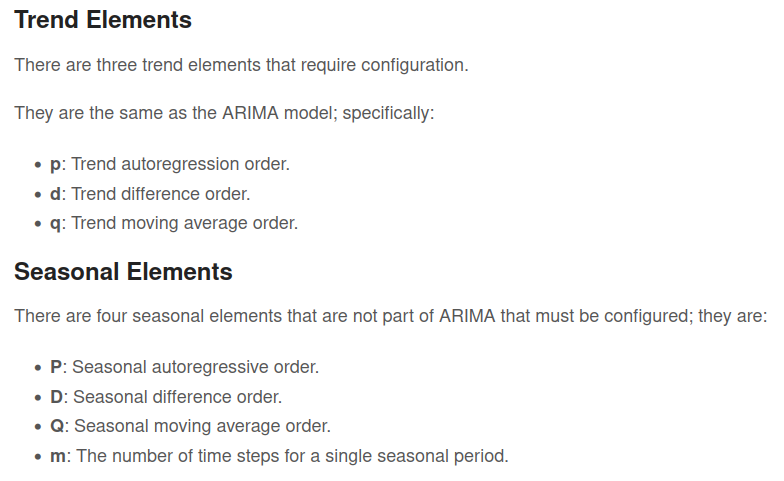


## The graphs above show a definitive seasonality (as expected !) 

## Using the Dicker-Fuller test we can test to stationality, a p value of 1.04x10^(-28) is much smaller than 0.05 and so even though the data is seasonal it is stationary.

In [409]:
# Dicker-Fuller test
dftest = adfuller(df.ActivePower, autolag = 'AIC')
print(" ADF : ",dftest[0])
print(" p-Value : ", dftest[1])
print(" Num Of Lags : ", dftest[2])
print(" Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print(" Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

 ADF :  -15.810134587509808
 p-Value :  1.049082674481178e-28
 Num Of Lags :  64
 Num Of Observations Used For ADF Regression and Critical Values Calculation : 78616
 Critical Values :
	 1% :  -3.430433182984783
	 5% :  -2.8615767654658493
	 10% :  -2.566789568990163


## The values of each of the required parameters p,d,q, P,D,Q and m can be worked out using the auto_arima function. However, since it is stationary the d value is 0.

## First to resample the data to daily as that is what we are trying to predict - the next 15 days worth of power generated.

In [410]:
# Since we want to simplify resample per day
df_daily  = df[['ActivePower','WindSpeed']].resample('D').mean()
df_daily.dropna(inplace=True) # drop and nas than get introduced

In [411]:
len(df_daily)

748

## Further evidence of the seasonal nature of the data set can be seen using the seasonal decompose function and setting the period = to 31 (a month)

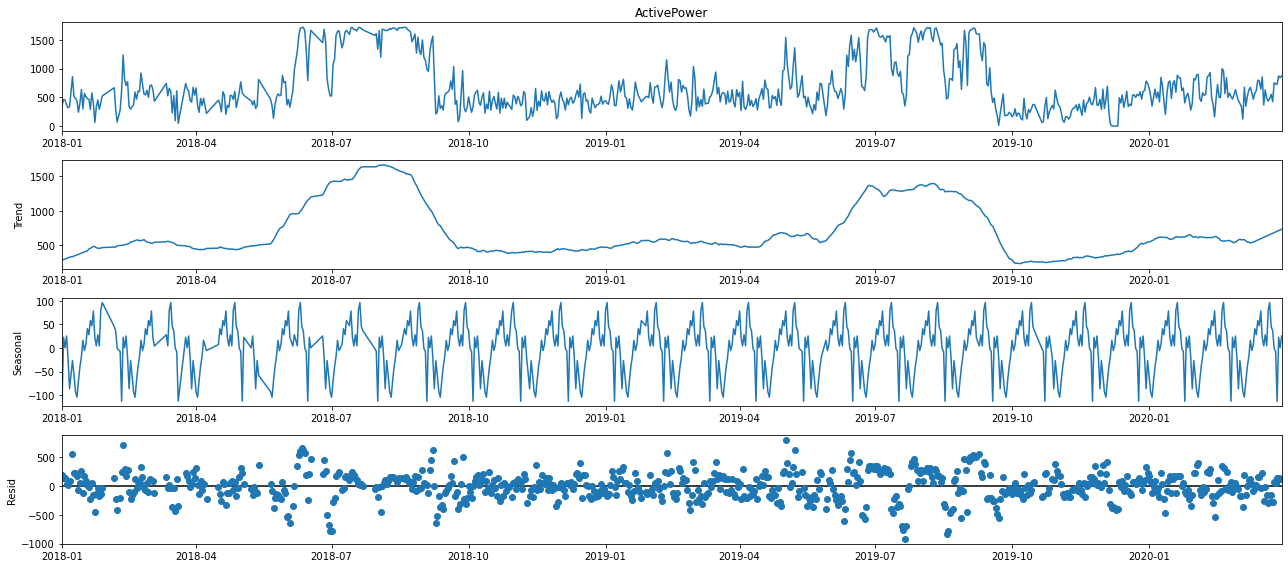

In [412]:
# decompase into seasonal/trend/residual
result = seasonal_decompose(df_daily['ActivePower'].dropna(), period=31, model='additive',extrapolate_trend=True)
result.plot()
plt.show()

In [413]:
model=pm.auto_arima(df_daily['ActivePower'],start_p=0,d=0,start_q=0,
          max_p=15,max_q=5, 
          start_P=0,D=0, start_Q=0, 
          max_P=8, max_Q=8, 
          m=12, seasonal=True, stationary=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=100)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=11272.369, Time=0.03 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=10179.151, Time=0.57 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=10630.572, Time=0.57 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=12170.384, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=10182.164, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=10177.292, Time=2.48 sec
 ARIMA(1,0,0)(3,0,0)[12] intercept   : AIC=10176.539, Time=9.33 sec
 ARIMA(1,0,0)(4,0,0)[12] intercept   : AIC=10178.464, Time=10.12 sec
 ARIMA(1,0,0)(3,0,1)[12] intercept   : AIC=10178.525, Time=7.95 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=10179.258, Time=2.11 sec
 ARIMA(1,0,0)(4,0,1)[12] intercept   : AIC=10179.874, Time=14.21 sec
 ARIMA(0,0,0)(3,0,0)[12] intercept   : AIC=10952.065, Time=10.63 sec
 ARIMA(2,0,0)(3,0,0)[12] intercept   : AIC=10163.698, Time=8.01 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=10163.991, Time=2.73 sec
 A

In [414]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  748
Model:               SARIMAX(6, 0, 0)   Log Likelihood               -5066.193
Date:                Sun, 14 Aug 2022   AIC                          10148.386
Time:                        16:28:43   BIC                          10185.325
Sample:                             0   HQIC                         10162.621
                                - 748                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     51.0112     18.230      2.798      0.005      15.281      86.742
ar.L1          0.6966      0.032     22.092      0.000       0.635       0.758
ar.L2          0.0732      0.036      2.009      0.045       0.002       0.145
ar.L3          0.0079      0.042      0.189      0.850      -0.074       0.089
ar.L4          0.0563      0.044      1.289      0.197      -0.029       0.142
ar.L5          0.0127      0.043      0.292      0.770      -0.072       0.098
ar.L6          0.0793      0.037      2.172      0.030       0.008       0.151
sigma2      4.492e+04   2083.061     21.563      0.000    4.08e+04     4.9e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                25.45
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                             0.15
Prob(H) (two-sided):                  0.30   Kurtosis:                         3.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [415]:
# Set up the SARIMA model with values as above
p = 6
d = 0
q = 0
P = 0
D = 0
Q = 0
m = 12

model = SARIMAX(df_daily['ActivePower'], order=(p,d,q), seasonal_order=(P,D,Q,m)) #- based on model.summary above we don't need the seasonal order part
model_fit = model.fit(disp=0) # disp=0 so no display
    
pred_day = model_fit.predict(start=1, end=len(df_daily['ActivePower']))


/opt/JupyterLab/resources/jlab_server/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/JupyterLab/resources/jlab_server/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/JupyterLab/resources/jlab_server/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [416]:
# make sure they have the same index (otherwise pred index gets set to 1970-01-01)
pred_day.index = df_daily['ActivePower'].index

In [417]:
df_final = pd.DataFrame(data={'Predictions':pred_day, 'Actuals':df_daily['ActivePower'] })  
df_final.head()

,Predictions,Actuals
2018-01-01 00:00:00+00:00,352.097245,366.223561
2018-01-02 00:00:00+00:00,429.333270,462.550740
2018-01-03 00:00:00+00:00,432.068231,454.417752
2018-01-04 00:00:00+00:00,370.204670,369.952190
2018-01-05 00:00:00+00:00,332.971991,319.446595


In [418]:
print('The Coefficient of determination (R-squared) = {:.2f}'.format(r2_score(df_final['Actuals'],df_final['Predictions'])))
print('The mean absolute error (MAE)                = {:.2f}'.format(mean_absolute_error(df_final['Actuals'],df_final['Predictions'])))
print('The RMSE error (RMSE)                        = {:.2f}'.format(mean_squared_error(df_final['Actuals'],df_final['Predictions'], squared=False)))
print('The Mean absolute percentage error (MAPE)    = {:.2f}'.format(mean_absolute_percentage_error(df_final['Actuals'],df_final['Predictions'])))   

The Coefficient of determination (R-squared) = 0.97
The mean absolute error (MAE)                = 53.61
The RMSE error (RMSE)                        = 72.12
The Mean absolute percentage error (MAPE)    = 1536784155996970.50


## A graph using the whole dataset is shown below

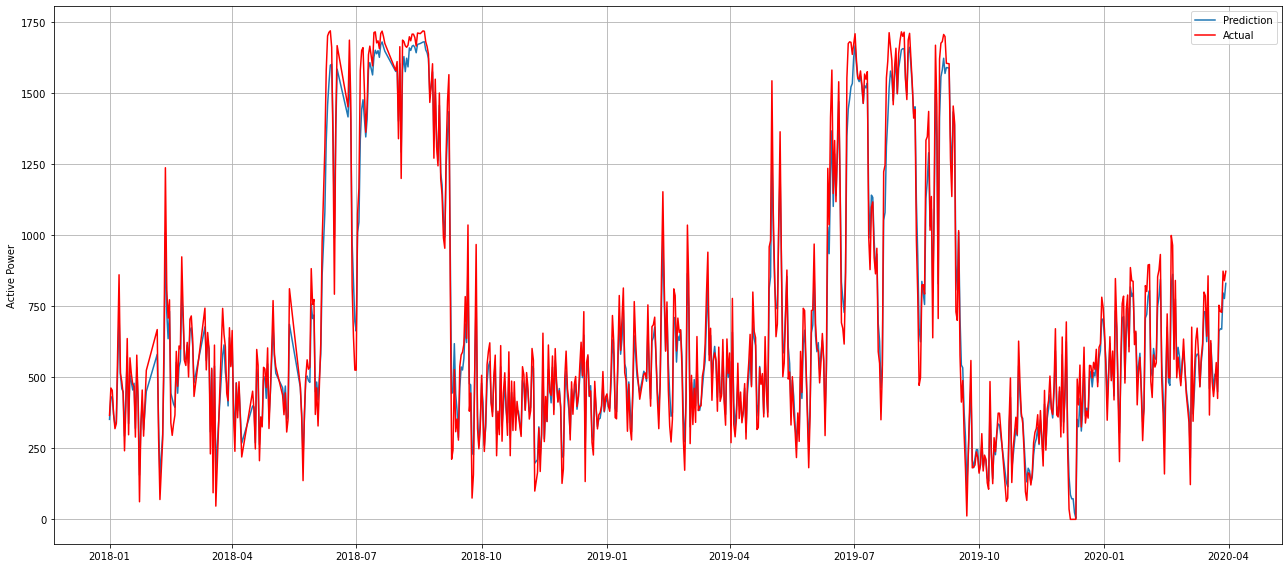

In [419]:
# plot
plt.plot(df_final['Predictions'],label='Prediction')
plt.plot(df_final['Actuals'], color='red',label='Actual')

plt.ylabel('Active Power')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

  # These results are very good but are based on the whole dataset - that is training the model on the whole dataset and then predicting on the same dataset that has already been used to learn - so of course the results are great - they should be.

## The next step is to forecast for the next 15 days. To do this I will set up 3 groups of training and testing data.

## The whole dataset minus the last 15 days as the test set.
## 80% of the data as train and then 15 days after that as test
## Two thirds of the data as training and then 15 days after that as test and then compare results.

## The results are not very good !

## Work out the number of observations and then work from there - 748

In [420]:
# work out the number of observations
len(df_daily['ActivePower'])

748

In [421]:
# train is from 0 to 733 test is from 733 to 748

train, test = df_daily[0:733], df_daily[733:748]
len(train), len(test)

(733, 15)

## Repeat the steps as above

In [422]:
train, test

(                           ActivePower  WindSpeed
 2018-01-01 00:00:00+00:00   366.223561   5.263797
 2018-01-02 00:00:00+00:00   462.550740   5.390719
 2018-01-03 00:00:00+00:00   454.417752   5.295225
 2018-01-04 00:00:00+00:00   369.952190   5.094994
 2018-01-05 00:00:00+00:00   319.446595   4.915224
 ...                                ...        ...
 2020-03-11 00:00:00+00:00   466.289248   5.385570
 2020-03-12 00:00:00+00:00   570.315539   5.693483
 2020-03-13 00:00:00+00:00   619.637333   5.765318
 2020-03-14 00:00:00+00:00   800.312824   6.217917
 2020-03-15 00:00:00+00:00   787.305117   6.458906
 
 [733 rows x 2 columns],
                            ActivePower  WindSpeed
 2020-03-16 00:00:00+00:00   644.891382   5.908178
 2020-03-17 00:00:00+00:00   857.485779   6.650817
 2020-03-18 00:00:00+00:00   367.360814   5.127046
 2020-03-19 00:00:00+00:00   629.455480   5.876625
 2020-03-20 00:00:00+00:00   485.411496   5.589186
 2020-03-21 00:00:00+00:00   432.529893   5.337225
 202

In [423]:
# use auto_arima on the training data alone - interestingly different results
model=pm.auto_arima(train['ActivePower'],start_p=0,d=0,start_q=0,
          max_p=15,max_q=5, 
          start_P=0,D=0, start_Q=0, 
          max_P=8, max_Q=8, 
          m=12, seasonal=True, stationary=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=100)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=11058.957, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=9980.519, Time=0.44 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=10426.421, Time=0.63 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=11931.508, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=9982.664, Time=0.06 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=9979.185, Time=1.81 sec
 ARIMA(1,0,0)(3,0,0)[12] intercept   : AIC=9977.965, Time=6.78 sec
 ARIMA(1,0,0)(4,0,0)[12] intercept   : AIC=9979.590, Time=21.31 sec
 ARIMA(1,0,0)(3,0,1)[12] intercept   : AIC=9979.889, Time=4.93 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=9978.776, Time=3.95 sec
 ARIMA(1,0,0)(4,0,1)[12] intercept   : AIC=9981.405, Time=8.04 sec
 ARIMA(0,0,0)(3,0,0)[12] intercept   : AIC=10745.163, Time=9.35 sec
 ARIMA(2,0,0)(3,0,0)[12] intercept   : AIC=9966.386, Time=8.01 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=9967.048, Time=2.59 sec
 ARIMA(2,0,0)(

In [424]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  733
Model:             SARIMAX(6, 0, 0)x(3, 0, 0, 12)   Log Likelihood               -4965.349
Date:                            Sun, 14 Aug 2022   AIC                           9952.697
Time:                                    16:36:53   BIC                          10003.266
Sample:                                         0   HQIC                          9972.203
                                            - 733                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     50.3115     17.709      2.841      0.004      15.603      85.020
ar.L1          0.7066      0.032     22.079      0.000       0.644       0.769
ar.L2          0.0611      0.037      1.638      0.102      -0.012       0.134
ar.L3          0.0073      0.043      0.172      0.863      -0.076       0.091
ar.L4          0.0536      0.045      1.198      0.231      -0.034       0.141
ar.L5          0.0078      0.044      0.179      0.858      -0.078       0.094
ar.L6          0.0806      0.037      2.184      0.029       0.008       0.153
ar.S.L12       0.0259      0.034      0.759      0.448      -0.041       0.093
ar.S.L24       0.0360      0.039      0.930      0.352      -0.040       0.112
ar.S.L36       0.0564      0.038      1.492      0.136      -0.018       0.131
sigma2      4.526e+04   2136.856     21.179      0.000    4.11e+04    4.94e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                24.65
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               0.89   Skew:                             0.14
Prob(H) (two-sided):                  0.35   Kurtosis:                         3.85
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [425]:
# Set up the SARIMA model with values as above
p = 6
d = 0
q = 0
P = 3
D = 0
Q = 0
m = 12

model = SARIMAX(train['ActivePower'], order=(p,d,q), seasonal_order=(P,D,Q,m), dynamic=True)
model_fit = model.fit(disp=0) # disp=0 so no display
    
test_pred = model_fit.predict(start=1, end=len(test['ActivePower']))

/opt/JupyterLab/resources/jlab_server/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/JupyterLab/resources/jlab_server/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [426]:
# make sure they have the same index (otherwise pred index gets set to 1970-01-01)
test_pred.index = test.index

In [427]:
df_final = pd.DataFrame(data={'Predictions':test_pred, 'Actuals':test['ActivePower'] })  
df_final.head()# use auto_arima on the training data alone - not surpisingly with only a small amount of reduced training data the results are the same


,Predictions,Actuals
2020-03-16 00:00:00+00:00,351.594829,644.891382
2020-03-17 00:00:00+00:00,429.686164,857.485779
2020-03-18 00:00:00+00:00,431.286345,367.360814
2020-03-19 00:00:00+00:00,368.746240,629.455480
2020-03-20 00:00:00+00:00,332.013630,485.411496


In [428]:
print('The Coefficient of determination (R-squared) = {:.2f}'.format(r2_score(df_final['Actuals'],df_final['Predictions'])))
print('The mean absolute error (MAE)                = {:.2f}'.format(mean_absolute_error(df_final['Actuals'],df_final['Predictions'])))
print('The RMSE error (RMSE)                        = {:.2f}'.format(mean_squared_error(df['ActivePower'],predicted_power, squared=False)))
print('The Mean absolute percentage error (MAPE)    = {:.2f}'.format(mean_absolute_percentage_error(df_final['Actuals'],df_final['Predictions'])))   

The Coefficient of determination (R-squared) = -1.89
The mean absolute error (MAE)                = 255.06
The RMSE error (RMSE)                        = 96.86
The Mean absolute percentage error (MAPE)    = 0.37


## A graph of predicted versus actual for last 15 days of the dataset

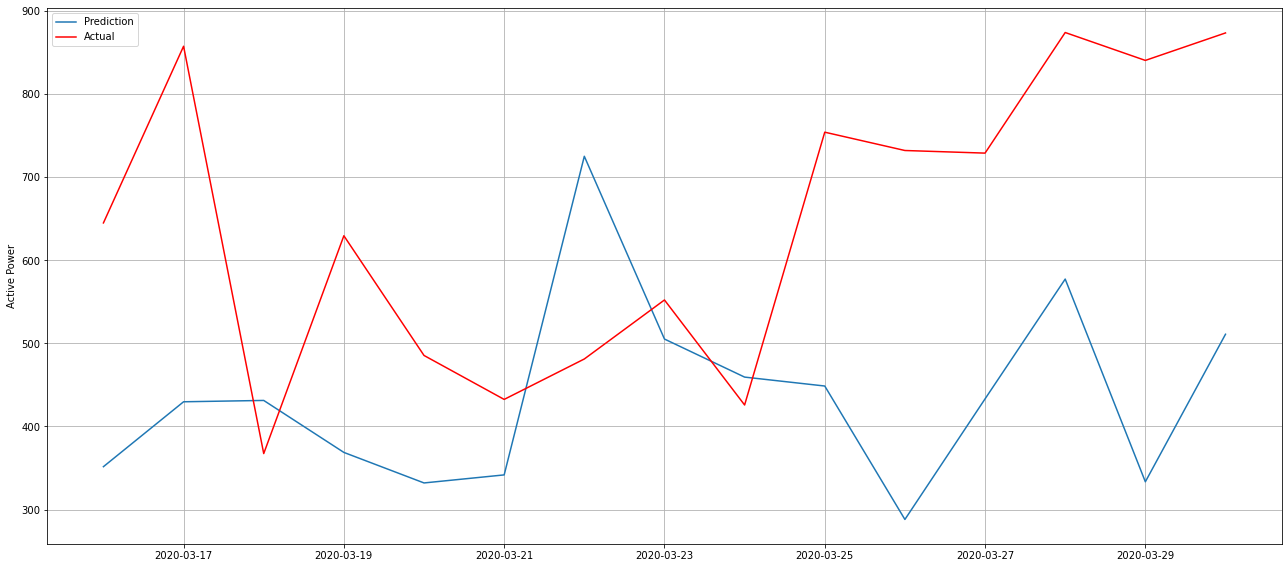

In [429]:
# plot
plt.plot(df_final['Predictions'],label='Prediction')
plt.plot(df_final['Actuals'], color='red',label='Actual')

plt.ylabel('Active Power')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

In [430]:
# 3/4 of 748 and 2/3 of 748
print('80% of 748 is {} and 2/3 of 748 is {}'.format(0.8*748, 2/3*748))


80% of 748 is 598.4 and 2/3 of 748 is 498.66666666666663


In [431]:
# train is from 0 to 597 test is from 601 to 601 + 15 (616)

train, test = df_daily[0:600], df_daily[600:615]

## Repeat the steps as above

In [432]:
model=pm.auto_arima(train['ActivePower'],start_p=0,d=0,start_q=0,
          max_p=15,max_q=5, 
          start_P=0,D=0, start_Q=0, 
          max_P=8, max_Q=8, 
          m=12, seasonal=True, stationary=True,
          error_action='warn',trace=True,
          supress_warnings=True,stepwise=True,
          random_state=20,n_fits=100)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=9119.746, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=8207.230, Time=0.50 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=8587.192, Time=0.60 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=9838.137, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=8210.868, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=8207.229, Time=1.79 sec
 ARIMA(1,0,0)(3,0,0)[12] intercept   : AIC=8206.799, Time=6.36 sec
 ARIMA(1,0,0)(4,0,0)[12] intercept   : AIC=8208.785, Time=11.00 sec
 ARIMA(1,0,0)(3,0,1)[12] intercept   : AIC=8208.511, Time=5.90 sec
 ARIMA(1,0,0)(2,0,1)[12] intercept   : AIC=8209.175, Time=1.67 sec
 ARIMA(1,0,0)(4,0,1)[12] intercept   : AIC=8210.477, Time=12.99 sec
 ARIMA(0,0,0)(3,0,0)[12] intercept   : AIC=8872.299, Time=9.58 sec
 ARIMA(2,0,0)(3,0,0)[12] intercept   : AIC=8199.281, Time=6.85 sec
 ARIMA(2,0,0)(2,0,0)[12] intercept   : AIC=8199.264, Time=2.18 sec
 ARIMA(2,0,0)(1,0

In [433]:
# Same values as original set up
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  600
Model:               SARIMAX(6, 0, 0)   Log Likelihood               -4085.663
Date:                Sun, 14 Aug 2022   AIC                           8187.326
Time:                        16:38:22   BIC                           8222.501
Sample:                             0   HQIC                          8201.019
                                - 600                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     49.8258     21.655      2.301      0.021       7.382      92.270
ar.L1          0.7162      0.036     19.916      0.000       0.646       0.787
ar.L2          0.0603      0.041      1.464      0.143      -0.020       0.141
ar.L3         -0.0008      0.047     -0.017      0.987      -0.093       0.092
ar.L4          0.0649      0.050      1.296      0.195      -0.033       0.163
ar.L5          0.0067      0.050      0.135      0.893      -0.091       0.104
ar.L6          0.0827      0.041      1.995      0.046       0.001       0.164
sigma2      4.836e+04   2514.456     19.234      0.000    4.34e+04    5.33e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                19.39
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                             0.13
Prob(H) (two-sided):                  0.30   Kurtosis:                         3.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [434]:
# Set up the SARIMA model with values as above
p = 6
d = 0
q = 0
P = 0
D = 0
Q = 0
m = 12

model = SARIMAX(train['ActivePower'], order=(p,d,q), seasonal_order=(P,D,Q,m))
model_fit = model.fit(disp=0) # disp=0 so no display
    
test_pred = model_fit.predict(start=1, end=len(test['ActivePower']))

/opt/JupyterLab/resources/jlab_server/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/opt/JupyterLab/resources/jlab_server/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [435]:
# make sure they have the same index (otherwise pred index gets set to 1970-01-01)
test_pred.index = test.index

In [436]:
df_final = pd.DataFrame(data={'Predictions':test_pred, 'Actuals':test['ActivePower'] })  
df_final.head()

,Predictions,Actuals
2019-11-04 00:00:00+00:00,351.943101,97.225429
2019-11-05 00:00:00+00:00,430.471609,66.762473
2019-11-06 00:00:00+00:00,431.844818,163.937559
2019-11-07 00:00:00+00:00,367.716704,160.739724
2019-11-08 00:00:00+00:00,331.649101,121.103679


In [437]:
print('The Coefficient of determination (R-squared) = {:.2f}'.format(r2_score(df_final['Actuals'],df_final['Predictions'])))
print('The mean absolute error (MAE)                = {:.2f}'.format(mean_absolute_error(df_final['Actuals'],df_final['Predictions'])))
print('The RMSE error (RMSE)                        = {:.2f}'.format(mean_squared_error(df_final['Actuals'],df_final['Predictions'],squared=False)))
print('The Mean absolute percentage error (MAPE)    = {:.2f}'.format(mean_absolute_percentage_error(df_final['Actuals'],df_final['Predictions'])))      

The Coefficient of determination (R-squared) = -3.26
The mean absolute error (MAE)                = 195.04
The RMSE error (RMSE)                        = 227.71
The Mean absolute percentage error (MAPE)    = 1.26


## A graph using 80% of the dataset for training to predict the 15 days after that.

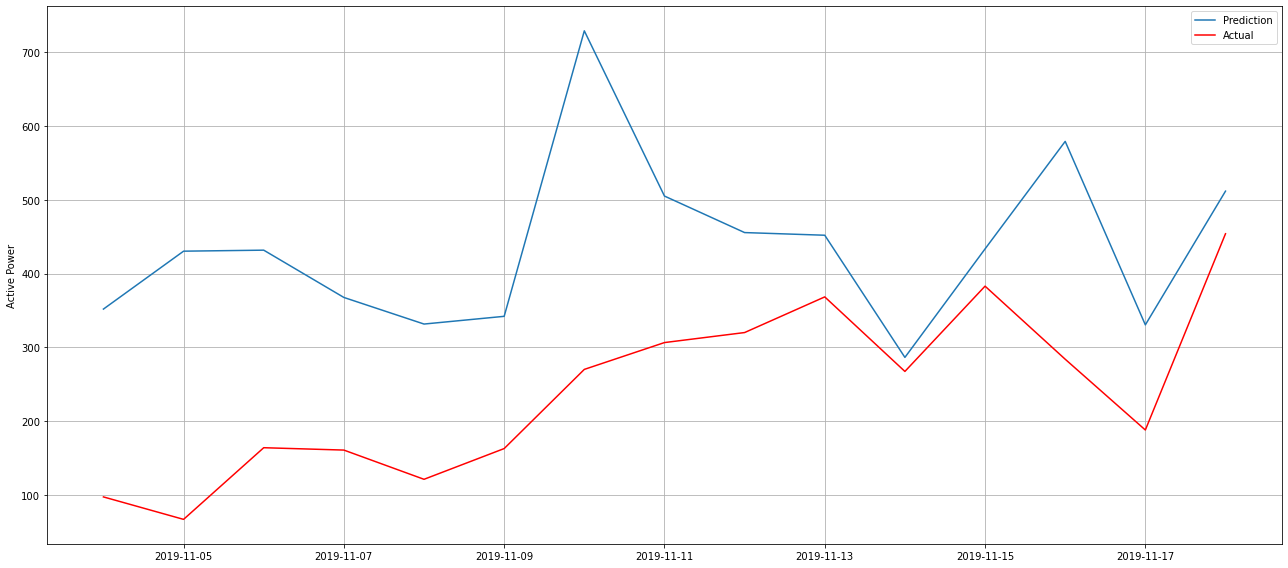

In [438]:
# plot
plt.plot(df_final['Predictions'],label='Prediction')
plt.plot(df_final['Actuals'], color='red',label='Actual')

plt.ylabel('Active Power')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

## Results for 2 previous steps (733 days and 600 days) weren't great so I didn't end up bothering with the 2/3 of the training data to run through.

# Now to investigate some other models to see if a better prediction can be made.

## Using XGBoost I will set the input values (x) as WindSpeed values and output (y) as the ActivePower values for training an XGBoost model
## Training data (X_train and y_train) is all the data without the last 15 days , then the testing data (X_test and y_test) values become the last 15 days as above.

## The XGBoost algorithm performs much better and the predictions are much closer to the actuals as can be seen from the graph below. An R2 score 0f 0.91 and lower MAE and RMSE

In [469]:
# train is from 0 to 733 test is from 733 to 748 - 

X_train, X_test, y_train,y_test = df_daily['WindSpeed'][0:733], df_daily['WindSpeed'][733:748], df_daily['ActivePower'][0:733],  df_daily['ActivePower'][733:748]
len(X_train),len(X_test),len(y_train),len(y_test)

(733, 15, 733, 15)

In [470]:
# define an XGBoost regressor
model = xgb.XGBRegressor(n_estimators=1000)

In [471]:
# Fit the model to the training data 
model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
          early_stopping_rounds=50, #stop if 50 consequent rounds without decrease of error
          verbose=False) 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [472]:
# Make the predictions
pred = model.predict(X_test)

In [473]:
df_final = pd.DataFrame(data={'Actuals':y_test, 'Predictions':pred })  

In [474]:
print('The Coefficient of determination (R-squared) = {:.3f}'.format(r2_score(df_final['Actuals'],df_final['Predictions'])))
print('The mean absolute error (MAE)                = {:.2f}'.format(mean_absolute_error(df_final['Actuals'],df_final['Predictions'])))
print('The RMSE error (RMSE)                        = {:.2f}'.format(mean_squared_error(df_final['Actuals'],df_final['Predictions'],squared=False)))
print('The Mean absolute percentage error (MAPE)    = {:.3f}'.format(mean_absolute_percentage_error(df_final['Actuals'],df_final['Predictions'])))   

The Coefficient of determination (R-squared) = 0.906
The mean absolute error (MAE)                = 42.07
The RMSE error (RMSE)                        = 52.95
The Mean absolute percentage error (MAPE)    = 0.062


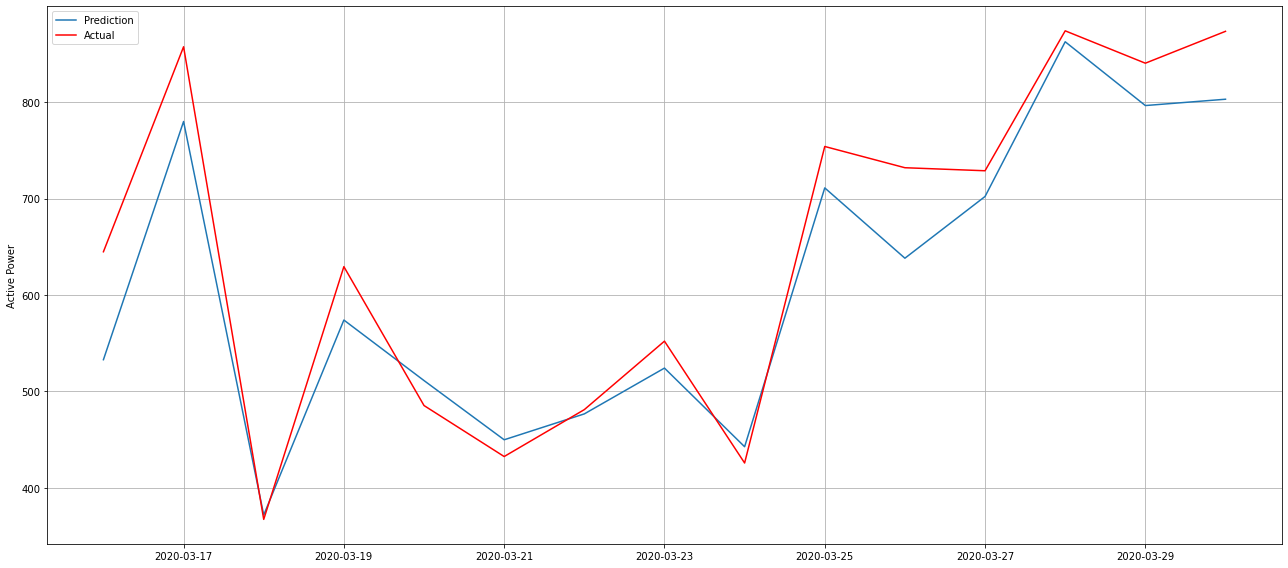

In [475]:
# plot
plt.plot(df_final['Predictions'],label='Prediction')
plt.plot(df_final['Actuals'], color='red',label='Actual')

plt.ylabel('Active Power')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

## Next I try a RandomForest regressor - repeat similar steps to above

In [476]:
# train is from 0 to 733 test is from 733 to 748 - 

X_train, X_test, y_train,y_test = df_daily[['WindSpeed']][0:733], df_daily[['WindSpeed']][733:748], df_daily[['ActivePower']][0:733],  df_daily[['ActivePower']][733:748]
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((733, 1), (15, 1), (733, 1), (15, 1))

In [477]:
# define the model parameters
model = RandomForestRegressor(n_estimators=1000) #, max_depth=2, max_features = 'sqrt',verbose = 1, bootstrap = False)

In [478]:
# Fit the model to the training data 
model.fit(X_train, y_train) 

/tmp/ipykernel_98969/263874903.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


RandomForestRegressor(n_estimators=1000)

In [479]:
# Make the predictions
pred = model.predict(X_test)

In [480]:
df_final = pd.DataFrame(data={'Actuals':y_test['ActivePower'], 'Predictions':pred}, index=y_test.index)  

In [482]:
print('The Coefficient of determination (R-squared) = {:.3f}'.format(r2_score(df_final['Actuals'],df_final['Predictions'])))
print('The mean absolute error (MAE)                = {:.2f}'.format(mean_absolute_error(df_final['Actuals'],df_final['Predictions'])))
print('The RMSE error (RMSE)                        = {:.2f}'.format(mean_squared_error(df_final['Actuals'],df_final['Predictions'],squared=False)))
print('The Mean absolute percentage error (MAPE)    = {:.3f}'.format(mean_absolute_percentage_error(df_final['Actuals'],df_final['Predictions'])))   

The Coefficient of determination (R-squared) = 0.913
The mean absolute error (MAE)                = 40.53
The RMSE error (RMSE)                        = 50.89
The Mean absolute percentage error (MAPE)    = 0.064


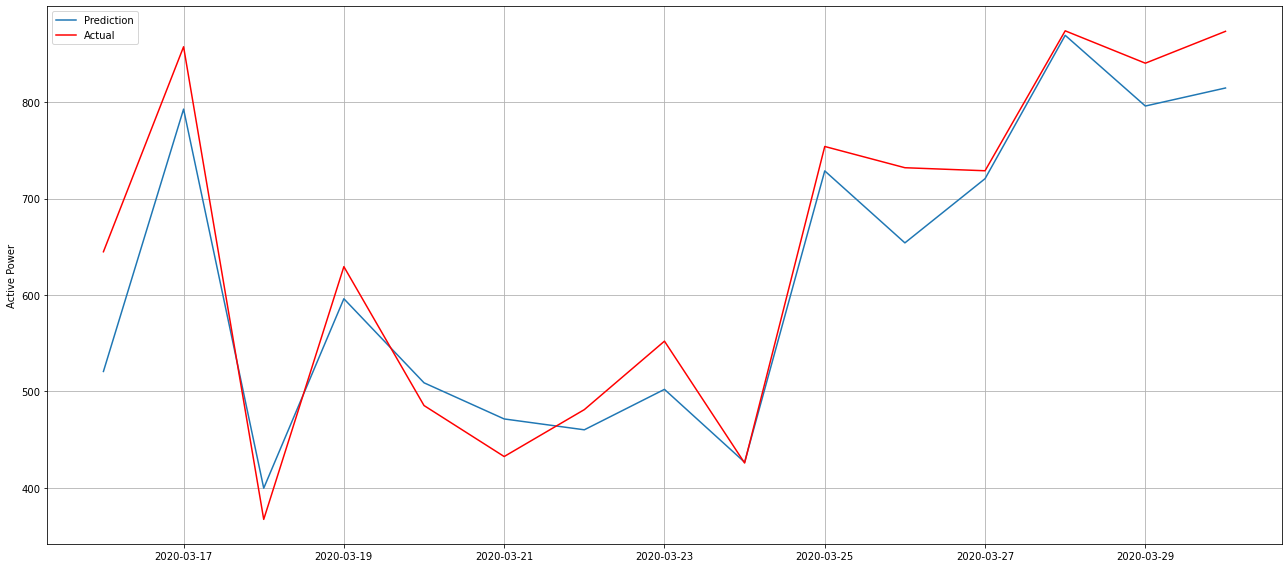

In [452]:
# plot
plt.plot(df_final['Predictions'],label='Prediction')
plt.plot(df_final['Actuals'], color='red',label='Actual')

plt.ylabel('Active Power')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

# An LSTM is the last thing that I will do. Using the same training data as above the first thing to do is to convert it into the right format to feed into the LSTM. In this case the values for X_train and y_train are somewhat different - now we use the values from multiple previous rows to predict the next ActivePower value. In this case I will use 35 rows of previous data as a guide to forecasting the next 15 values (this makes sense given there is a monthly pattern)

## So the first 698 values are reserved for training and the last 50 for testing.

## After lots of playing around with changing the number of neurons and batch size I simply could not acheive good results using an LSTM

In [453]:
# train is from 0 to 698 test is from 698 to 748
  
train, test = df_daily['ActivePower'][0:698], df_daily['ActivePower'][698:748]
train.shape,test.shape

((698,), (50,))

In [454]:
scaler = MinMaxScaler(feature_range=(0,1))
#scaler.fit(train)
train = scaler.fit_transform(train.values.reshape(-1,1))
test = scaler.transform(test.values.reshape(-1,1))

In [455]:
# define a function to create X and y  sets from the  training dataset
# still need to reshape input to be 3D [samples, timesteps, features]

def split_X_y(df, n_steps_in, n_steps_out):
    X, y = [],[]
    for i in range(len(df)):
        # find the end of this pattern
        end_index = i + n_steps_in
        out_end_index = end_index + n_steps_out
        # check if we are beyond the sequence
        if out_end_index > len(df):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = df[i:end_index], df[end_index:out_end_index]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [456]:
# choose a number of time steps
n_steps_in, n_steps_out = 35, 15
# split into samples
train_X, train_y = split_X_y(train, n_steps_in, n_steps_out)
test_X, test_y   = split_X_y(test, n_steps_in, n_steps_out)
train_X.shape, train_y.shape, test_X.shape, test_y.shape

((649, 35, 1), (649, 15, 1), (1, 35, 1), (1, 15, 1))

In [457]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
train_X_res = train_X.reshape((train_X.shape[0], train_X.shape[1], n_features))
train_y_res = train_y.reshape((train_y.shape[0], train_y.shape[1], n_features))

test_X_res  = test_X.reshape((test_X.shape[0], test_X.shape[1], n_features))
test_y_res  = test_y.reshape((test_y.shape[0], test_y.shape[1], n_features))
train_X_res.shape, train_y_res.shape, test_X_res.shape, test_y_res.shape

((649, 35, 1), (649, 15, 1), (1, 35, 1), (1, 15, 1))

In [458]:
# define model
model = Sequential()
# 1st layer 128 neurons, return sequence is true to stack the next layer and dropout set at 20% and BatchNormalization
model.add(LSTM(128, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(Dropout(0.2))
model.add(BatchNormalization())

# 2nd layer 64 neurons, return sequence is now false so it returns and dropout set at 20%
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(Dropout(0.2))
model.add(BatchNormalization())

# final layer is the number of days of forecasts needed
model.add(Dense(n_steps_out)) 


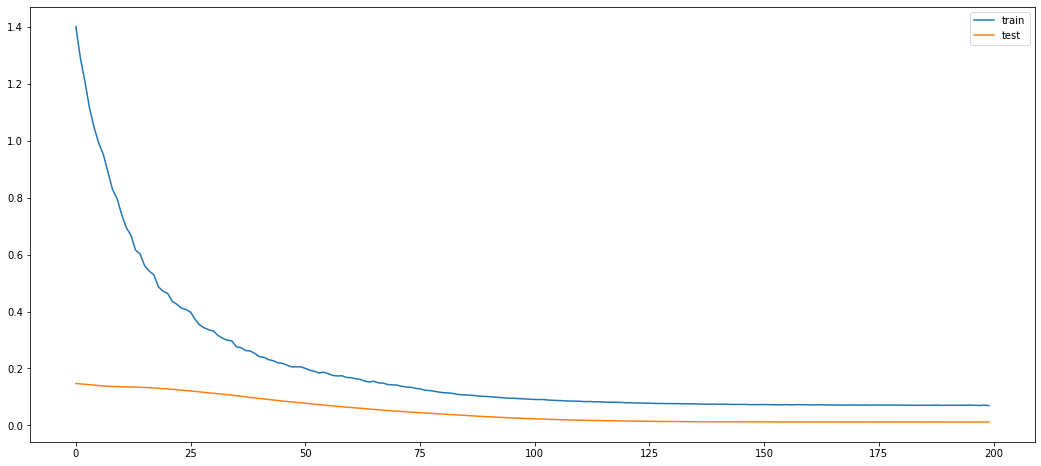

In [459]:
4# Compile and run the model amd plot the loss function, num epochs set at 200 but early stopping means should not reach that
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()]) 
#  early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=20)
# fit network 
history = model.fit(train_X_res, train_y_res, epochs=200,verbose=0, batch_size=64, validation_data=(test_X_res,  test_y_res), shuffle=False, callbacks=[es]) 
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [460]:
# demonstrate prediction
prediction = model.predict(test_X_res, verbose=0)
#print(scaler.inverse_transform(prediction))
pred = scaler.inverse_transform(prediction)

In [461]:
pred[0][0:15]

array([673.6496 , 720.8195 , 634.3469 , 686.64966, 759.9938 , 688.4081 ,
       709.09814, 670.71674, 761.9883 , 746.11816, 610.07153, 645.02356,
       691.06287, 694.4057 , 678.25446], dtype=float32)

In [462]:

df_final = pd.DataFrame(data={'Actuals':df_daily['ActivePower'][733:748], 'Predictions':pred[0][0:15]}, index = df_daily[733:748].index)  

In [463]:
df_final

,Actuals,Predictions
2020-03-16 00:00:00+00:00,644.891382,673.649597
2020-03-17 00:00:00+00:00,857.485779,720.819519
2020-03-18 00:00:00+00:00,367.360814,634.346924
2020-03-19 00:00:00+00:00,629.455480,686.649658
2020-03-20 00:00:00+00:00,485.411496,759.993774
2020-03-21 00:00:00+00:00,432.529893,688.408081
2020-03-22 00:00:00+00:00,481.172384,709.098145
2020-03-23 00:00:00+00:00,552.187880,670.716736
2020-03-24 00:00:00+00:00,425.815287,761.988281
2020-03-25 00:00:00+00:00,754.076163,746.118164


In [464]:
print('The Coefficient of determination (R-squared) = {:.2f}'.format(r2_score(df_final['Actuals'],df_final['Predictions'])))
print('The mean absolute error (MAE)                = {:.2f}'.format(mean_absolute_error(df_final['Actuals'],df_final['Predictions'])))
print('The RMSE error (RMSE)                        = {:.2f}'.format(mean_squared_error(df_final['Actuals'],df_final['Predictions'],squared=False)))
print('The Mean absolute percentage error (MAPE)    = {:.2f}'.format(mean_absolute_percentage_error(df_final['Actuals'],df_final['Predictions'])))   

The Coefficient of determination (R-squared) = -0.19
The mean absolute error (MAE)                = 162.71
The RMSE error (RMSE)                        = 187.76
The Mean absolute percentage error (MAPE)    = 0.30


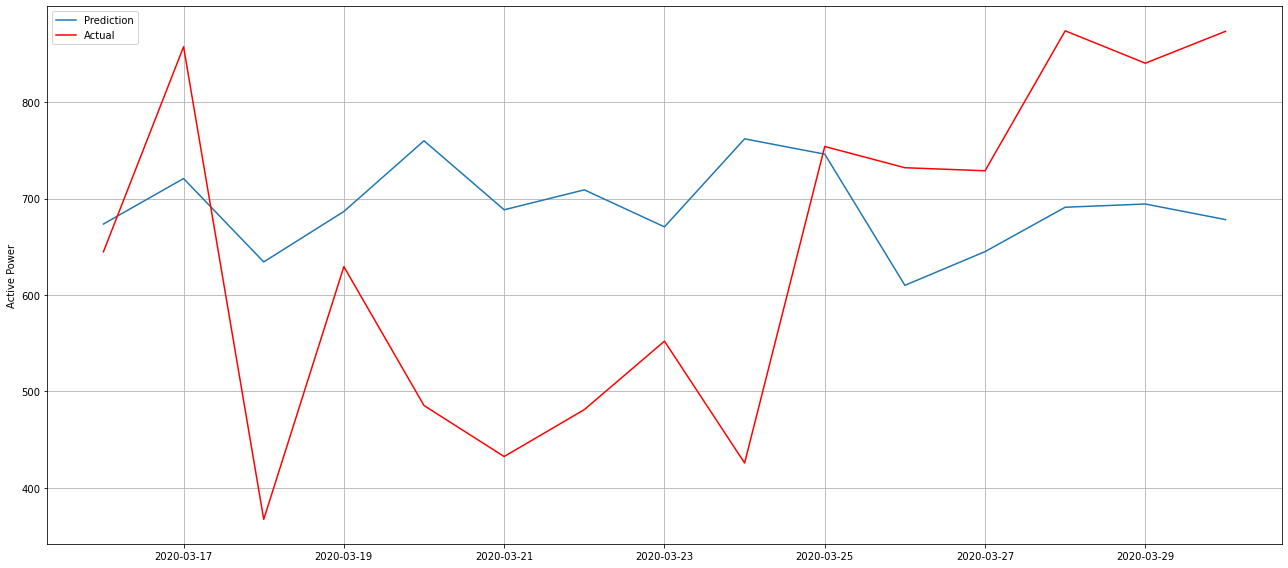

In [465]:
# plot
plt.plot(df_final['Predictions'],label='Prediction')
plt.plot(df_final['Actuals'], color='red',label='Actual')

plt.ylabel('Active Power')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()

# Results and discussion

## Originally when I started this work I thought that a SARIMA model would work best given the state of the data - namely that there was seasonal component to it. However, the proved not to be the case. Also I thought using an LSTM neural network would provide good results but this was also not true. In the end it was the simplest methods that provided the best results - that is both the RandomForest and XGBoost regressors - with RandomForest being slightly better (the R squared better but MAPE slightly worse but I had to go to 3 figures to differentiate).

## Overall the general statement that can be made is that either of XGBoost or Randomforest regressor could predict the next 15 days of power output to roughly 94% accurracy (or a mean average percentage error of 6%) and that roughly 91% of the variance in the data (R squared) is explained by either method.

### Note without a random_state set for each method the exact results may differ slightly

|Method|R^2|RMSE|MAE|MAPE|
|---|---|---|---|---|
|SARIMAX (733 days training)|-1.89|225.06|96.86|0.34|                                                            
|SARIMAX (600 days training)|-3.26|195.04|227.71|1.26|
|Extreme gradient boost (XGBoost)|0.906|42.07|52.95|0.062|
|RandomForestRegressor| 0.915|40.54|50.99|0.064|
|LSTM|-0.19|162.71|187.76|0.30|